In [1]:
%load_ext autoreload
%autoreload 2
import bardensr
import IPython.display
import tensorflow as tf
import numpy as np
import scipy as sp
import scipy.spatial
import numpy.random as npr
import matplotlib.pylab as plt
%matplotlib inline
import tqdm.notebook
import matplotlib
matplotlib.rcParams['image.cmap'] = 'gray'

# Introduction to bardensr

The `bardensr` (barcode dexmixing through non-negative spatial regression) package is a collection of tools for modeling observations with the following three properties:

1. The observations can be understood as a matrix $\mathbf{X} \in \mathbb{R}^{M\times N}$.  The row index, $m\in \{0\cdots M-1\}$ is considered to be **spatial**.  We will assume there is some smooth topology along this index.  In the typical case this will be a 1d, 2d, or 3d topology.   For example, each column of $\mathbf{X}$ could correspond to a rectangular $200 \times 300$ image.  In this case, we would have $M =200 \times 300 = 60000$.  In this case, each possible value of $m$ would correspond to a particular pixel in this image, and the observations could also be understood as a 3-tensor $\mathbf{X} \in \mathbb{R}^{200 \times 300 \times N}$.  However, for our purposes, we will always view $\mathbf{X}$ as a matrix.  
2. Each observation is non-negative (i.e. $\mathbf{X}_{mn}\geq 0$ for every $m,n$)
3. We believe that there are matrices $\mathbf{G},\mathbf{F},\mathbf{K}$ such that the observations approximately satisfy the following tri-linear equation:
$$\mathbf{X}_{mn} \approx \sum_{i,k} \mathbf{G}_{nk} \mathbf{F}_{i k} \mathbf{K}_{m,i}$$

In the third property, above, we mention three matrices.  We give these matrices names:
- $\mathbf{F}$ -- "the density" -- a matrix $\mathbf{F} \in \mathbb{R}^{M\times J}$ with non-negative entries
- $\mathbf{K}$ -- "the kernel" -- a **symmetric** matrix $\mathbf{K} \in \mathbb{R}^{M\times M}$ with non-negative entries (typically a blur kernel)
- $\mathbf{G}$ -- "the mixing matrix" -- a matrix $\mathbf{G} \in \mathbb{R}^{N\times J}$ with non-negative entries

This package was originally designed to be useful for those building pipelines for analyzing spatial transcriptomics datasets.  In this context $M$ represents the total number of voxels, so there is also additional topological structure in $\mathbf{X}$ (each voxel corresponds to a position in space).  Smoothness along this topology can be enforced by taking $\mathbf{K}$ to be a blur kernel.  For example, if analyzing images of a slice of tissue which are 400 pixels wide, 500 pixels long, and 10 pixels deep, we would take $M=400 \times 500 \times 10=2000000$ and $K$ might be a 3-dimensional blur kernel.

This package may also be helpful for other problems with similar mathematical structure.

# The core capabilities of the bardensr package

The core of bardensr lies in the following functions.  These functions are designed to operate on tensorflow2 tensors, so that they can be used on either GPU or CPU hardware.


In [2]:
IPython.display.display(bardensr.ipydoc(bardensr.programs.iterate_nonnegative_quadratic))
IPython.display.display(bardensr.ipydoc(bardensr.programs.iterate_matrix_nnls))
IPython.display.display(bardensr.ipydoc(bardensr.programs.solve_diagonal_nnls))
IPython.display.display(bardensr.ipydoc(bardensr.programs.solve_square_nnls))

-------
 ### `iterate_nonnegative_quadratic`

Consider the problem of optimizing

$$L(y)=\frac{1}{2} \sum_{ij} y_i y_j \Gamma_{ij} - \sum_i y_i \phi_i$$

subject to the constraint that $y_i>=\mathtt{lo}$ for every $i$.

The function `nonnegative_quadratic_iteration` helps with this problem.  Given an initial guess $y$,
this function finds a new value $y'$ such that $L(y')\leq L(y)$.

The algorithm works by making a cleverly chosen guess at a search direction and
a cleverly chosen guess about how far to go in that direction.   If going that far
makes the objective worse, we try going a little less far (this is called
backtracking).  If it still doesn't work we back track a little more.  If it
still doesn't work we backtrack yet more.  We do this a couple more times and then
give up.


```
Input:
- apply_Gamma -- a callable that takes a tf2 vector y and returns a new vector with the same shape
- phi -- a tf2 vector
- y -- a tf2 vector which is the same shape as phi
- [optional] lo=0
- [optional] backtracking=.9 --  how much to backtrack.  For example, backtracking=.9 means if
at first we don't succeed we will try going only 90% of the distance we went at first.
- [optional] maxiter=10 -- we repeat the backtracking process "maxiter" iterations until
we make some improvement or until maxiter is reached.

The callable apply_Gamma should apply a symmetric positive definite linear transformation to its input.

Ouput: a new guess for y.  Designed to reduce the loss function
  loss(y) = .5*tf.reduce_sum(y*apply_Gamma(y)) - tf.reduce_sum(y*phi)
```


-------
 ### `iterate_matrix_nnls`

Consider the loss

$$L(\mathbf{F}) = \frac{1}{2} \sum_{mn} \left(\mathbf{X}_{mn} -\sum_{i,k} \mathbf{G}_{nk} \mathbf{F}_{i k} \mathbf{K}_{m,i}\right)^2 + \lambda \sum_{mn}\sum_{i,k} \mathbf{G}_{nk} \mathbf{F}_{i k} \mathbf{K}_{m,i}$$
Given an initial nonnegative guess for $\mathbf{F}$, this function makes a new guess for
F that is nonnegative and doesn't make the loss worse (and might make it better).

    Input:
    - X -- a (M x N) tf2 tensor
    - G -- a (N x J) tf2 tensor
    - F -- a (M x J) tf2 tensor
    - K -- a callable that takes a tf2 matrix of shape (M \times ?) and returns a tf2 matrix of shape (M \times ?)
    - lam (scalar)
    - [optional] backtracking=.9
    - [optional] maxiter=10

    The callable K should apply a symmetric linear transformation to each row of its input.

    See nonnegative_quadratic_iteration for details on the meaning of backtracking and maxiter

    Output: a new guess for F



-------
 ### `solve_diagonal_nnls`

Consider the loss

$$L(\alpha) = \frac{1}{2} \sum_{mn} \left(\mathbf{X}_{mn} - \mathbf{\tilde{X}}_{m,n} \alpha_{n} \right)^2 + \lambda \sum_{mn}\mathbf{\tilde{X}}_{m,n} \alpha_{n}$$

This function finds the best value for $\alpha$ subject to the constarint $\alpha_n > \mathtt{lo}$ for each $n$.

    Input:
    - X -- a (M x N) tf2 tensor
    - Xt -- a (M x N) tf2 tensor
    - lam (scalar)
    - lo (scalar)
    - [optional] denomthresh=1e-10
    - [optional] defaultvalue=1

    Output: best possible alpha

If sum_m X_mn^2 =0 for some n, this is ill-posed for alpha[n].  So if
sum_m X_mn^2<denomthresh for a particular n we set the value of alpha[n] to
whatever is in "defaultvalue"


-------
 ### `solve_square_nnls`

Consider the loss

$$L(\varphi) = \frac{1}{2} \sum_{mn} \left(\mathbf{X}_{mn} - \sum_{n'} \mathbf{\tilde{X}}_{m,n'} \varphi_{n,n'} \right)^2 + \lambda \sum_{mn}\sum_{n'}  \mathbf{\tilde{X}}_{m,n'} \varphi_{n,n'} + \frac{1}{2}\epsilon \sum_{n,n'} \varphi_{n,n'}^2$$

This function uses sp.optimize.nnls to find the best possible value for $\varphi$.  This function is slow if $n$ is large.

Input:
- X -- a (M x N) tf2 tensor
- Xt -- a (M x N) tf2 tensor
- lam -- scalar
- [optional] -- eps=1e-10 (for numerical stability)

Output: best possible varphi


# demo: `iterate_matrix_nnls`  can demix data through nonnegative 1d spatial regression

Here we'll create a simulation where $\mathrm{F},\mathrm{G},\mathrm{K},\mathrm{X}$ are all known.  We'll then look at several vignettes showing how  `bardensr` can be used solve different problems.  For example, we can recover $\mathrm{F}$ given knowledge of $\mathrm{G},\mathrm{K},\mathrm{X}$.

### Create a simulated dataset

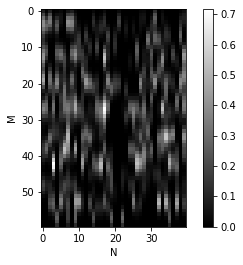

In [3]:
# pick sizes
M = 60
N = 40
J = 45

# Construct a sparse mixing matrix, G
G_sparsity = npr.randn(N,J)>.9
G = npr.rand(N,J)+.2
G[~G_sparsity]=0
G=tf.convert_to_tensor(G)

# Construct an example sparse density matrix, F
F_sparsity = npr.randn(M,J)>2
F = npr.rand(M,J)+.2
F[~F_sparsity]=0
F=tf.convert_to_tensor(F)

# construct a kernel K (this should be a CALLABLE which implements a symmetric linear operator on Mx? matrices)
def K(F):
    # we here use the heat_kernel which is a symmetric 1d blur kernel 
    return bardensr.kernels.heat_kernel(F,5,axis=0)

# construct some data
X=K(F)@tf.transpose(G)

# let's look at it
plt.imshow(X.numpy())
plt.xlabel("N")
plt.ylabel("M")
plt.colorbar()

### Vignettte I: given the observations X and knowledge of G and K, can we reconstruct F?


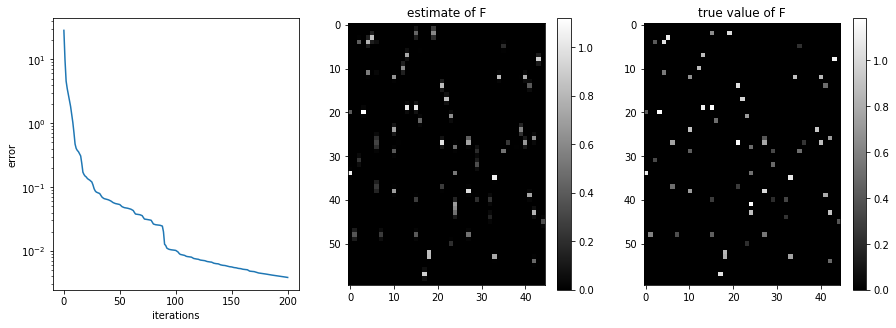

In [4]:

# get initial guess and initial error
F_guess = tf.zeros_like(F)
errors = [bardensr.programs.calc_matrix_nnls_loss(X,G,F_guess,K,0)]

# apply updates
for i in tqdm.notebook.tqdm(range(200)):
    F_guess=bardensr.programs.iterate_matrix_nnls(X,G,F_guess,K,0)
    errors.append(bardensr.programs.calc_matrix_nnls_loss(X,G,F_guess,K,0))
    
# plot what happened
plt.gcf().set_size_inches(15,5)

plt.subplot(1,3,1)
plt.plot(errors)
plt.gca().set_yscale('log')
plt.ylabel('error')
plt.xlabel('iterations')

plt.subplot(1,3,2)
plt.imshow(F_guess.numpy())
plt.title("estimate of F")
plt.colorbar()


plt.subplot(1,3,3)
plt.imshow(F.numpy())
plt.title("true value of F")
plt.colorbar()

Yes we can! In fact, if we wait long enough, we'll get essentially exactly the right answer (problem is convex!)

### Vignette II: What if we are given a corrupted version of X?

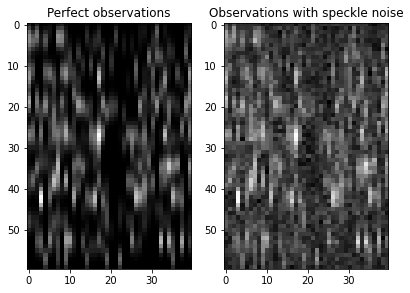

In [5]:
# corrupt the data
X_corrupted=X+.05*tf.random.normal(X.shape,dtype=X.dtype)

# look at it
plt.gcf().set_size_inches(10,5)
plt.subplot(1,3,1)
plt.imshow(X.numpy())
plt.title("Perfect observations")

plt.subplot(1,3,2)
plt.imshow(X_corrupted.numpy())
plt.title("Observations with speckle noise");

Can we guess F from this noisy data?

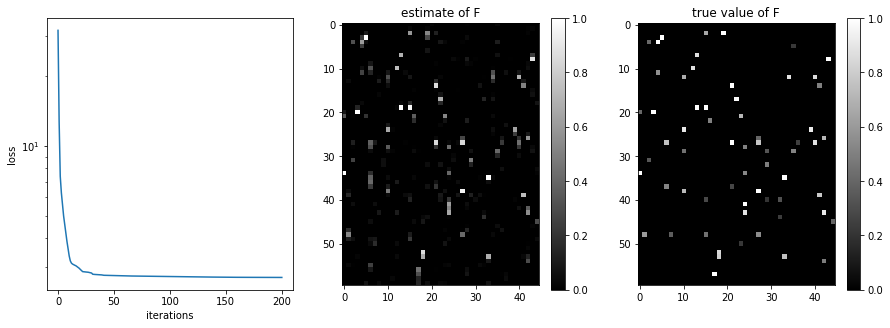

In [6]:
# get initial guess and initial error
F_guess = tf.zeros_like(F)
losses = [bardensr.programs.calc_matrix_nnls_loss(X_corrupted,G,F_guess,K,0)]

# apply updates
for i in tqdm.notebook.tqdm(range(200)):
    F_guess=bardensr.programs.iterate_matrix_nnls(X_corrupted,G,F_guess,K,0)
    losses.append(bardensr.programs.calc_matrix_nnls_loss(X_corrupted,G,F_guess,K,0))
    
# plot what happened
plt.gcf().set_size_inches(15,5)

plt.subplot(1,3,1)
plt.plot(losses)
plt.gca().set_yscale('log')
plt.ylabel('loss')
plt.xlabel('iterations')

plt.subplot(1,3,2)
plt.imshow(F_guess.numpy(),vmin=0,vmax=1)
plt.title("estimate of F")
plt.colorbar()


plt.subplot(1,3,3)
plt.imshow(F.numpy(),vmin=0,vmax=1)
plt.title("true value of F")
plt.colorbar()

Our estimate looks ok, though not perfect.  In particular, the levels of brightness are maybe not always right.   If our task is to find out the places where F was nonzero, how well can we actually do?  We could try to threshold our estimate... but then how would we pick the threshold?

To deal with this, we can use the "unused barcodes" trick.

### Vignette III: Finding nonzero values of $F$ using the "unused barcodes trick" and L1 regularization

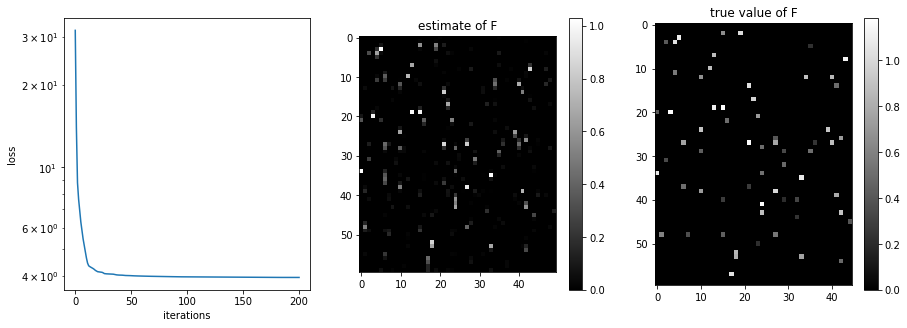

In [7]:
# Augment G with some additional columns.  We call these columns the "unused barcodes"
n_augmentations=5
Ga_sparsity = npr.randn(N,n_augmentations)>.9
Ga = npr.rand(N,n_augmentations)
Ga[~Ga_sparsity]=0
G_augmented=tf.convert_to_tensor(np.c_[G.numpy(),Ga])
Ja=J+n_augmentations

# we'll also use a small L1 penalty to help send small signals to zero
lam=.005

# get initial guess and initial error with these augmented codes
F_guess = tf.zeros((M,Ja),dtype=tf.float64)
losses = [bardensr.programs.calc_matrix_nnls_loss(X_corrupted,G_augmented,F_guess,K,lam)]

# apply updates
for i in tqdm.notebook.tqdm(range(200)):
    F_guess=bardensr.programs.iterate_matrix_nnls(X_corrupted,G_augmented,F_guess,K,lam)
    losses.append(bardensr.programs.calc_matrix_nnls_loss(X_corrupted,G_augmented,F_guess,K,lam))
    
# plot what happened
plt.gcf().set_size_inches(15,5)

plt.subplot(1,3,1)
plt.plot(losses)
plt.gca().set_yscale('log')
plt.ylabel('loss')
plt.xlabel('iterations')

plt.subplot(1,3,2)
plt.imshow(F_guess.numpy())
plt.title("estimate of F")
plt.colorbar()


plt.subplot(1,3,3)
plt.imshow(F.numpy())
plt.title("true value of F")
plt.colorbar()

Let's try to find the locations at which F was nonzero.  To do so we will threshold our estimate of F and compare it to the set of locations in the true F.

In [8]:
# The unused barcodes can help us set a threshold to pick our guesses
thresh=np.median(tf.reduce_max(F_guess[:,-n_augmentations:],axis=0).numpy())
above_thresh=F_guess[:,:-n_augmentations].numpy()>2*thresh

One way test the agreement between the sets of locations is as follows.

1. For each nonzero location that we found (m,n), is there a corresponding ground-truth (m',n) with |m-m'| < 3?


67/70 points we found are close to some ground-truth point


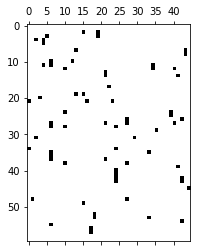

In [9]:
n_found=np.sum([
    bardensr.diagnostics.pointset_agreement(np.where(x)[0][:,None],np.where(y)[0][:,None],3) 
    for (x,y) in zip(above_thresh.T,F.numpy().T)])
print(f'{n_found}/{np.sum(above_thresh)} points we found are close to some ground-truth point')

plt.spy(above_thresh)

2. For each nonzero location in groundtruth (m,n), is there a corresponding point we found (m',n) with |m-m'| < 3?


55/63 points in the ground truth are close to some point we found


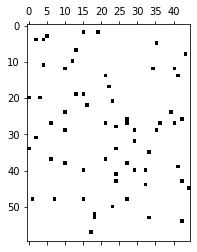

In [10]:
n_found=np.sum([
    bardensr.diagnostics.pointset_agreement(np.where(y)[0][:,None],np.where(x)[0][:,None],3) 
    for (x,y) in zip(above_thresh.T,F.numpy().T)])
print(f'{n_found}/{np.sum(F.numpy()!=0)} points in the ground truth are close to some point we found')

plt.spy(F.numpy()!=0)

# demo: `iterate_matrix_nnls`  can demix data through nonnegative 3d spatial regression

Here we'll look at similar problems to those above -- except now we will assume that each column of $X$ actually corresponds to an image-stack.  In this case, there is a 3-dimensional topology to the structure of each row, which we can take advantage of.  To do so, we will use a 3-dimensional blur kernel.

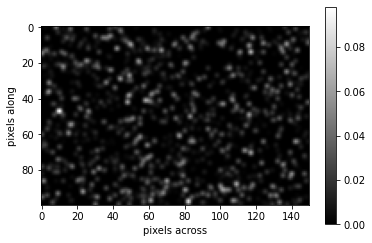

In [11]:
# pick sizes
pixels_wide=100
pixels_long=150
pixels_deep=5
M = pixels_wide*pixels_long*pixels_deep
N = 40
J = 45

# Construct a sparse mixing matrix, G
G_sparsity = npr.randn(N,J)>.9
G = npr.rand(N,J)+.2
G[~G_sparsity]=0
G=tf.convert_to_tensor(G)

# Construct an example sparse density matrix, F
F_sparsity = npr.randn(M,J)>3
F = npr.rand(M,J)+.2
F[~F_sparsity]=0
F=tf.convert_to_tensor(F)

# construct a kernel K (this should be a CALLABLE which implements a symmetric linear operator on Mx? matrices)
def K(F):
    # we here use the heat_kernel which is a symmetric 3d blur kernel along the M
    F=tf.reshape(F,(pixels_wide,pixels_long,pixels_deep,-1))
    F=bardensr.kernels.heat_kernel_nd(F,[2,2,2])
    return tf.reshape(F,(M,-1))
    
# construct some data
X=K(F)@tf.transpose(G)

# let's look at a slice of it (we can't see the whole thing... its too big now!)
Xsl=tf.reshape(X[:,25],(pixels_wide,pixels_long,pixels_deep))
plt.imshow(Xsl[:,:,2].numpy())
plt.xlabel("pixels across")
plt.ylabel("pixels along")
plt.colorbar()

We can reconstruct F from corrupted data

In [12]:
# corrupt the data
X_corrupted=X+.005*tf.random.normal(X.shape,dtype=X.dtype)

In [13]:
# get initial guess and initial error
F_guess = tf.zeros_like(F)
losses = [bardensr.programs.calc_matrix_nnls_loss(X_corrupted,G,F_guess,K,0)]

# apply updates -- this is pretty fast on GPU, less so on CPU
trange=tqdm.notebook.tqdm(range(20))
for i in trange:
    F_guess=bardensr.programs.iterate_matrix_nnls(X_corrupted,G,F_guess,K,0)
    losses.append(bardensr.programs.calc_matrix_nnls_loss(X_corrupted,G,F_guess,K,0))
    trange.set_description(f"loss={losses[-1]:.2e}")
    

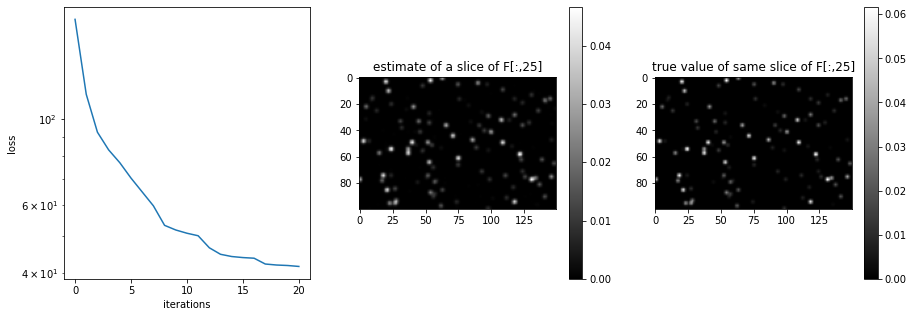

In [14]:
# plot what happened
plt.gcf().set_size_inches(15,5)

plt.subplot(1,3,1)
plt.plot(losses)
plt.gca().set_yscale('log')
plt.ylabel('loss')
plt.xlabel('iterations')

plt.subplot(1,3,2)
plt.imshow(K(F_guess).numpy()[:,25].reshape((pixels_wide,pixels_long,pixels_deep))[:,:,2])
plt.title("estimate of a slice of F[:,25]")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(K(F).numpy()[:,25].reshape((pixels_wide,pixels_long,pixels_deep))[:,:,2])
plt.title("true value of same slice of F[:,25]")
plt.colorbar()